# Is South Africa delaying the inevitable?

# Introduction

South Africa seems to be leading the way in successfully stemming the flow of the COVID 19 and keeping community transmissions reasonably low-that is a success that no one else has achieved. Our people are scared -as they should be- they have more questions than answers: Can SA escape the worst of this epidemic? Is exponential spread unavoidable? The answer is NO. According to Prof Salon Abdool Karim who currently chairs the Ministerial Advisory Group for the trends and next steps in combating the virus in SA, the reason is simply because all of us have no immunity against it. He was quoted saying "SA will not escape unless she has a special protective mojo not present anywhere else in the world".

I'm not here to shutter hopes, that is not my intention, but my question is "why then is South Africa not on the expected Covid19 epidemic trajectory". Why is our curve unique. Is it even unique or are we simply delaying the inevitable I.e a delayed spiral of cases after the lockdown. These are the questions we explore in this notebook. Most of the data comes from a huge central repository created by the team at Explore AI, although some will be exctracted from wikipedia for purposes that will be explained in the coming sections. The database is a collection of publicly available data delivered to the community through APIs. The code below will pull the various tables into our environment.

In [2]:
### Load packages

library(tidyverse)
library(lubridate)
library(janitor)
library(magrittr)
library(ggrepel)


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'janitor' was built under R version 3.6.3"
Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test



In [25]:
### Load data

# Tables from the Explore database
casesLocal <- read_csv('casesLocal.csv')
testsLocal <- read_csv('testsLocal.csv')
counterMeasures <- read_csv('counterMeasures.csv')
casesGlobal <- read_csv('casesGlobal.csv')

# Table pulled from an independent github repository
url <- 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
testsGlobal <- read_csv(url)

# Tables extracted from wikipedia
responsesGlobal <- read_csv('responsesGlobal.csv') 
populationGlobal <- read_csv('populationGlobal.csv') 

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_date(format = ""),
  confirmed = col_double(),
  country_id = col_double(),
  id = col_double(),
  location = col_character(),
  location_level = col_character()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_date(format = ""),
  country = col_character(),
  cumulative_tests = col_double()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_date(format = ""),
  country = col_character(),
  measure = col_character(),
  value = col_double()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_date(format = ""),
  active = col_double(),
  active_dailiy_growth_rate = col_double(),
  active_rolling_3_day_growth_rate = col_double(),
  confirmed = col_double(),
  confirmed_daily = col_double(),
  country

# Data descriptions

We have a total of 7 tables. Explore provided local cases and local covid19 testing tables (by local I mean South African data), as well as counter measures and cases on a global level. First we note that the although global cases is a comprehensive data table with more 180 countries around the world, the table does not contain any data about covid_19 testing in the various countries. It also does not contain any data regarding the population in those various countries. Also, the counterMeasures table seems comprehensive, consisting of information such as social distancing and work from home initiatives that many countries have implemented since the dawn of the virus. We are of the view that an important measure that many countries have implemented is officially declaring a national lockdown. We go to wikipedia 'https://en.wikipedia.org/wiki/National_responses_to_the_2019%E2%80%9320_coronavirus_pandemic' to find a table with lockdown dates indicated for several countries. We also get the global population table 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population' ,both from publicly available tables on wikipedia. We further get the global testing table from an independent source in a github repo 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'. The importance of these additional tables is explained in the sections to come.

# Data transformations

Before we begin anwering the questions we have in mind, it is necessary to first transform our data into a form that is easy for processing. The following blocks of code are meant to achieve that purpose. What I will mention here however is the following: 

1. Most studies that have been done to date with regrds to the cross-sectional impact of COVID_19 across countries have tended to focus on the number of confirmed cases or active cases. While these values might seem like a plausible option, they lead to common misconceptions. How many times have we seen on the news the that United States is being hit the worst by the virus? The population in America is in the 350 millions, approximately, and a 700000 infected patients is a mild less than 0.2% of that population. To give you some contrast lets take another country, say UK. In UK the population is in the 65 millions, approximately, and 700000 infected patients account for 1.05% of that population. Seems like an insignificant difference, but a statistician will tell you that if you're a UK citizen you are 5 times more likely to get the virus than a United States citizen. For this reason, we will visualise confirmed cases on a standardised scale. In other words, we will assume every country has a population of 1 million people so that 700000 cases is the same in UK as in the United States. We also standardise other values i.e the number of tests done in a country per thousand, the number of deaths per thousand confirmed cases and the number of recoveries per thousand confirmed cases.

2. The lifecycle of the virus differs across the countries. Some countries had their first infection as far back as in January (China for example). Therefore comparing their current statistics with a country whose virus is only a few weeks old is not plausible. Lets take United States again as an example. If America is in its 80th day of the virus surely its numbers cannot be compared with South Africa whose virus is  only 40 or so days. These number of days are just an illustration. As a result, our axis instead of reflecting dates, they will reflect Number of days since virus inception.

Lets get on with data transformation. I hope in-code comments will help.

In [26]:
### Columns renaming and dropping redundancy

# simply giving United State a more explicit name
casesGlobal %<>%
  mutate(country = ifelse(country == 'US', 'United States', country)) 

# columns of interest in the casesGlobal table
columns_of_interest <- 
  c(
    'date', 'country', 
    'active', 'active_dailiy_growth_rate', 'active_rolling_3_day_growth_rate', 'daily_change_in_active_cases',
    'confirmed', 'deaths', 'recovered'
    )

casesGlobal %<>%
  mutate(date = X1) %>%
  select(columns_of_interest)

# select columns of interest in the testsGlobal table and renaming location columns to country as in other tables
testsGlobal %<>% 
  select(
    date, location, total_tests, new_tests, total_tests_per_thousand, new_tests_per_thousand, tests_units
  ) %>%
  rename(country = location)

# selection only the country and population column 
populationGlobal %<>%
  set_names(c('X', 'Rank', 'country', 'population', '%_of_world_pop', 'date', 'source')) %>%
  select(country, population)

# Certain countries have a start_date for the lockdown but some like the UK didn't provide an end date, even to the press
# However, the United States did provide these values in the press, we insert the date provided by the state New York
responsesGlobal[responsesGlobal$country == 'United States', c('end')] <- date('2020-05-15')

# Countries that did not provide end dates for their lockdown will have an arbitrary value of 31 Dec 2020
# The new dataframe will be save as lockdown_data
responsesGlobal %>%
  replace_na(replace = list(end = date('2020-12-31'))) %>%
  select(country, start, end) %>% 
  distinct  ->
  lockdown_data

In [27]:
### Joining tables into one dataframe (df) 
# Note that tables of local data will not be joined. That is because local data at country level is available in the 
# tables with rest of the other countries. If we are interested in provincial level data later, we will then find use 
# for them

casesGlobal %>%
  select(columns_of_interest) %>%
  left_join(
    testsGlobal  %>% 
      select(date, country, total_tests),
    by = c("date", "country")
  ) %>% 
  left_join(
    populationGlobal,
    by = 'country'
  ) %>%
  left_join(
    lockdown_data, 
    by = 'country'
  ) ->
  df
df %>% head

date,country,active,active_dailiy_growth_rate,active_rolling_3_day_growth_rate,daily_change_in_active_cases,confirmed,deaths,recovered,total_tests,population,start,end
2020-02-24,Afghanistan,1,NA,NA,NA,1,0,0,NA,32225560,NA,NA
2020-02-25,Afghanistan,1,0,NA,0,1,0,0,NA,32225560,NA,NA
2020-02-26,Afghanistan,1,0,NA,0,1,0,0,NA,32225560,NA,NA
2020-02-27,Afghanistan,1,0,0,0,1,0,0,NA,32225560,NA,NA
2020-02-28,Afghanistan,1,0,0,0,1,0,0,NA,32225560,NA,NA
2020-02-29,Afghanistan,1,0,0,0,1,0,0,NA,32225560,NA,NA


In [86]:
# Adding extra columns 
# 1. to indicate number of days since the first case was reported
# 2. to indicate the lockdown periods

all_countries = df %>% '$'(country) %>% unique    # take all countries in casesGlobal
countries_w_lockdown_data <- lockdown_data %>% '$'(country) %>% unique     # take countries with lockdown data

# Note that ceratin countries are not included in the lock_down data table.
# That is probably because those countries have not implemented the measure... I'm just guessing.
# Either way the data is not available so the loop below should know that.

daily_data <- tibble()

for (i in all_countries) {
  
  lower <- lockdown_data  %>% filter(country == i) %>% '$'(start)
  upper <- lockdown_data  %>% filter(country == i) %>% '$'(end)
  
  # This is where we tell the loop how to treat a country name that is there in globalCases but not there 
  # in lockdown_data.
  # If it is in lockdown_data we want the column 'lockdown' to indicate with 1 for the lockdown period
  # and 0 otherwise.
  if(i %in% countries_w_lockdown_data) {
    df %>%
      filter(country == i) %>% 
      fill(total_tests, .direction = c('down')) %>%
      mutate(lockdown = ifelse(date >= lower & date <= upper, '1', '0')) ->
      data
  }
  # If it is in not lockdown_data we want the column 'lockdown' to indicate with 1 for the lockdown period
  # and 0 otherwise.
  else {
    df %>%
      filter(country == i) %>% 
      fill(total_tests, .direction = c('down')) %>%
      mutate(lockdown = NA)  ->
      data
  }
  # Add the day column
  data %>%
    mutate(Day = c(1:nrow(data))) %>%
    rbind(
      daily_data
    )  %>%
    select(date, Day, country, everything()) -> 
    daily_data
  
}

# Calculate the standardised statistics
daily_data %<>%
  mutate(
    'Infections per Million' = round((confirmed / population) * 1000000, 2),
    'Tests per Thousand' = round((total_tests / population) * 1000, 2),
    'Infections per Thousand Tested' = round((confirmed / total_tests) * 1000, 0),
    'Deaths per Thousand Confimed Cases' = round((deaths / confirmed) * 1000, 0),
    'Recoveries per Thousand Confirmed Cases' = round((recovered / confirmed) * 1000, 0) 
    ) 
# Print the head of the final dataset
daily_data %>% head

date,Day,country,active,active_dailiy_growth_rate,active_rolling_3_day_growth_rate,daily_change_in_active_cases,confirmed,deaths,recovered,total_tests,population,start,end,lockdown,Infections per Million,Tests per Thousand,Infections per Thousand Tested,Deaths per Thousand Confimed Cases,Recoveries per Thousand Confirmed Cases
2020-03-20,1,Zimbabwe,1,NA,NA,NA,1,0,0,NA,15159624,2020-03-30,2020-05-02,0,0.07,NA,NA,0,0
2020-03-21,2,Zimbabwe,3,2.0000000,NA,2,3,0,0,NA,15159624,2020-03-30,2020-05-02,0,0.20,NA,NA,0,0
2020-03-22,3,Zimbabwe,3,0.0000000,NA,0,3,0,0,NA,15159624,2020-03-30,2020-05-02,0,0.20,NA,NA,0,0
2020-03-23,4,Zimbabwe,2,-0.3333333,0.2599208,-1,3,1,0,NA,15159624,2020-03-30,2020-05-02,0,0.20,NA,NA,333,0
2020-03-24,5,Zimbabwe,2,0.0000000,-0.1264194,0,3,1,0,NA,15159624,2020-03-30,2020-05-02,0,0.20,NA,NA,333,0
2020-03-25,6,Zimbabwe,2,0.0000000,-0.1264194,0,3,1,0,NA,15159624,2020-03-30,2020-05-02,0,0.20,NA,NA,333,0


A first natual step in our analysis will be to compare the data for South Africa with other countries. Further, instead of arbitrarily selecting a sample of countries to compare based on press, we choose to take a somewhat data driven approach.
We will filter data based of certain metrics i.e confirmed cases as well as our computed starndadised metrics. For example, by taking the twenty top countries by confirmed cases and plotting their series since first day of inception we get a plot as displayed below.

In [87]:
### Setting global settings for visualisations themes 

theme_set(
  theme_bw()
)

In [88]:
# First generate a filter dataset

daily_data %>% 
  group_by(country) %>%
  summarise(
    highest_transmission_rate = max(`Infections per Million`, na.rm = T),
    highest_infection_rate = max(`Infections per Thousand Tested`, na.rm = T),
    highest_confirmed= max(confirmed, na.rm = T),
    highest_avg_roll_growth_rate = max(active_rolling_3_day_growth_rate, na.rm = T),
    highest_death_rate = mean(`Deaths per Thousand Confimed Cases`, na.rm = T),
    highest_recovery_rate = max(`Recoveries per Thousand Confirmed Cases`, na.rm = T)
  ) ->
  filter_data

filter_data %>% head(3)

Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Million`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning me

"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Thousand Tested`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Thousand Tested`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Thousand Tested`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Thousand Tested`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Thousand Tested`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Thousand Tested`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Thousand Tested`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning message in max(`Infections per Thousand Tested`, na.rm = T):
"no non-missing arguments to max; returning -Inf"Warning

country,highest_transmission_rate,highest_infection_rate,highest_confirmed,highest_avg_roll_growth_rate,highest_death_rate,highest_recovery_rate
Afghanistan,26.07,-Inf,840,0.709975,13.86792,66
Albania,182.01,-Inf,518,1.223978,42.48718,535
Algeria,52.74,-Inf,2268,1.289427,69.07692,368


In [89]:
# This is a user function for generating the plot we are interested in

plot_graph <- function(df, column, .filter) {
  
  df %>%
    select(date, Day, country, column) %>%
    filter(country %in% .filter) %>%
    gather(feature, value, -c('date', 'Day', 'country')) ->
    daily_data_trans
  
  daily_data_trans %>%
    group_by(country, feature) %>%
    summarise(Day = max(Day, na.rm = T),
    value = max(value, na.rm = T)) ->
    mask
    
  daily_data_trans  %>%
    ggplot(aes(Day, value, color = country)) +
    geom_line() +
    facet_wrap( ~ feature, scales = 'free_y', nrow = 2, strip.position = 'left') +
    geom_point(data = mask) +
    geom_text_repel(aes(label = country), 
                    data = mask,
                    vjust = -1) +
    scale_x_continuous(breaks = seq(0, length(daily_data_trans$Day %>% unique), 5)) +
    scale_y_continuous(labels = scales::comma) +
    theme(
      legend.position = 'none',
      strip.placement = 'outside'
    ) +
    labs(
      x = 'Number of days since inception', y = '',
      title = 'Top Countries by Confirmed Cases (A comparison with South Africa)'
    ) -> 
    fig1 
  
  return(fig1) 
}

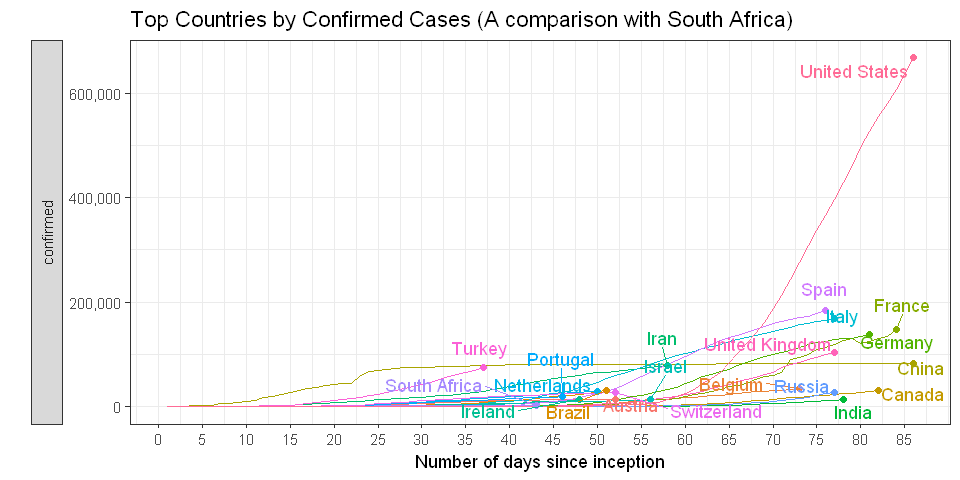

In [90]:
# then get the top countries by confirmed cases. Include South Africa for comparison.
filter_data %>%
  top_n(n = 20, wt = highest_confirmed) %>%
  '$'(country) %>%
  union(c('South Africa')) ->
  top_countries_by_confirmed

# generate the plot
options(repr.plot.width = 8, repr.plot.height = 4)
plot_graph(
  df = daily_data, column = 'confirmed', .filter = top_countries_by_confirmed
) ->
  fig1

print(fig1)

There is only one thing that is clear from the above figure. That is "it is the figure i warned you about". Looking at absolute cases one would conclude that the United States is a typical worst cases senario. But believe me it is not. Look at the following figure. Here we've standardised the y_scale. We are assuming that every nation has a population of a million and display confirmed cases per that million population.

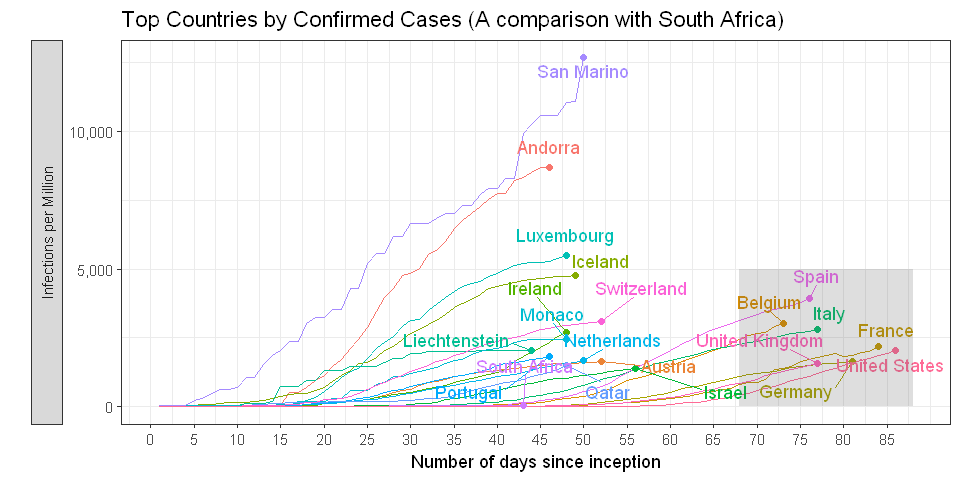

In [91]:
# Again we include South Africa for comparison's sake
filter_data %>% 
  top_n(n = 20, wt = highest_transmission_rate) %>%
  '$'(country) %>%
  union(c('South Africa')) ->
  top_countries_by_transmission
  
# generate the plot
options(repr.plot.width = 8, repr.plot.height = 4)
plot_graph(
  df = daily_data, column = 'Infections per Million', .filter = top_countries_by_transmission
) ->
  fig2

fig2 +
  annotate('rect', xmin = 68, xmax = 88, ymin = 0, ymax = 5000, alpha = .2)

Now, look what happens to the United States. China was there in the first figure but has disappeared now. San Marino and Andora I wont even discuss. Ofcoarse this is probably because these countries have extremely low populations, it's 33574 in San Marino to be precise. But this figure is truer reflection of the cross-sectional impact of the virus across the selected countries. Why? Because San Marino will get wiped out at this rate. But America will not, atleast not at the same rate as San Marino. Where is South Africa. Down there is where she is. Ofcoarse its only day 43 in South Africa, but look at how she fares relative to the other countries who have a virus that is only as old as hers, Ireland, Luxembourg etc. Looking at Spain, Italy and the other candidates in the shaded region, it is clear they were once where South Africa is. Maybe we are hearded that same trajectory. Is it unique. NOT REALLY. It seems normal that the number of cases spirals around day 48 to 50, look at Belgium and Spain, or even later(day 55 to 60), look at United States and France for example.Perhaps the correct title for my notebook would have been "Is South Africa Really On A Unique Trajectory?".

Furthermore, one would make a proposition that maybe South Africa is not doing enough tests in her population, especially in disadvantages communities. For one, we know that South Africa has taken an active approach to testing. Rather waiting for patients to come forward, there are currently about 28000 health cares workers out there conducting tests in disadvantaged communities. If the figure above is an honest depiction of the virus's impact in South Africa, we expect to have low rates of infection per thousand tests. The code block below filters the data to get the countries with the lowest confirmed cases per thousand people tested and generates a figure exactly the same as above for this group. South Africa is not necessarily in that group but is included either way. We hope to see her display similar characteristics as most of the candidates in that group. If not ...

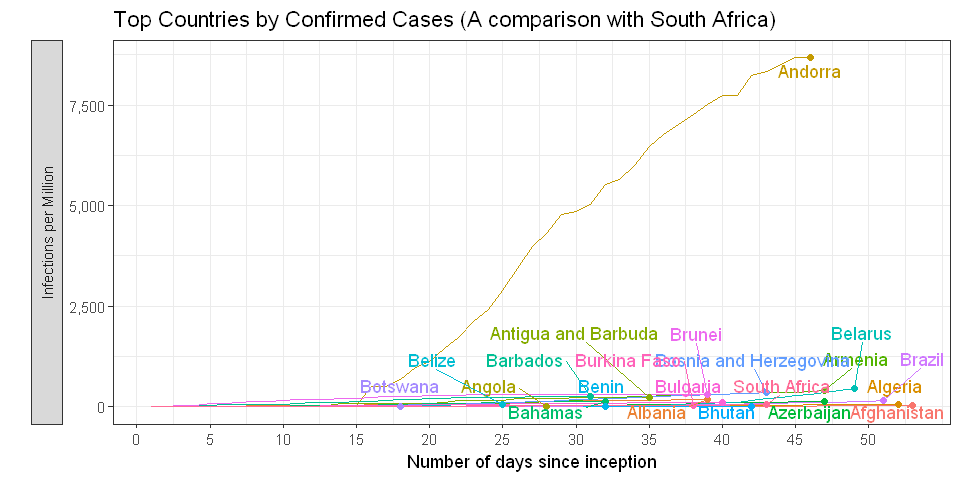

In [92]:
# get least infected countries per thousand tested
filter_data %>%
  arrange(highest_infection_rate) %>% # default arranges by ascending order
  '$'(country) %>%
  .[c(1:20)] %>%
  union(c('South Africa')) ->
  bottom_countries_by_infection

# generate plot
# Note that although we filtered by confirmed cases per thousand we still plot confirmed cases per million population
options(repr.plot.width = 8, repr.plot.height = 4)
plot_graph(
  df = daily_data, column = 'Infections per Million', .filter = bottom_countries_by_infection
) -> 
  fig3

fig3 

I was saying, if not, she would behave like Andora. Look at that. Andora is a perfect illustration of how South Africa would behave in this figure if there wasn't enough testing being done. Think about it for a second, Andora appears in our initial figure as a candidate recording high infections per million population. Then the data is filtered to get candidate countries with low infections per thousand tested, and she makes it into that list too. Odd. Maybe not. This is exactly what would happen if your tests are too low relative to your population. The logic is as follows: If most of you population is infected and only a small fraction of your tested population is infected, then most of your population has not been tested. Lets be glad South Africa did not display such behaviour. The story about these testing statistics is not over. Lets investigate the point even further. 

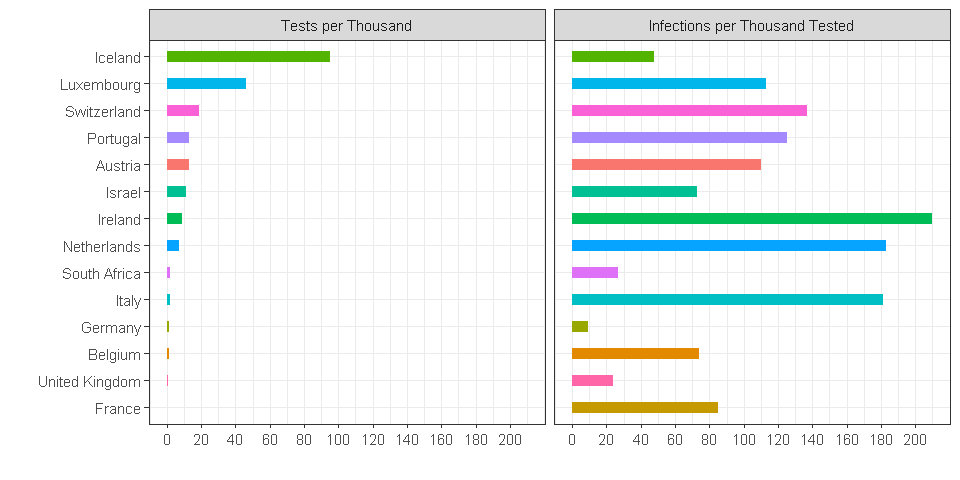

In [98]:
current_day_sa <- daily_data %>% filter(country == 'South Africa') %>% '$'(Day) %>% max()

daily_data %>% 
  select(Day, country, `Tests per Thousand`, `Infections per Thousand Tested`) %>%
  filter(country %in% c(top_countries_by_transmission)) %>%
  gather(feature, value, -c('Day', 'country')) %>%
  filter(Day == current_day_sa) %>%
  arrange(feature, value) %>%
  mutate(feature = factor(feature, levels = c('Tests per Thousand', 'Infections per Thousand Tested'))) ->
  tests_data 
  
options(repr.plot.width = 8, repr.plot.height = 4)
tests_data %>%
  na.omit %>%
  ggplot(aes(reorder(country, value, min), value, fill = country)) +
  geom_col(width = .4) +
  facet_wrap( ~ feature) +
  theme(
    legend.position = 'none'
  ) +
  scale_y_continuous(breaks = seq(0, 200, 20)) +
  labs(
    x = '', y = ''
  ) +
  coord_flip() 